In [1]:
#pip install folium

In [2]:
import pandas as pd
import seaborn as sns

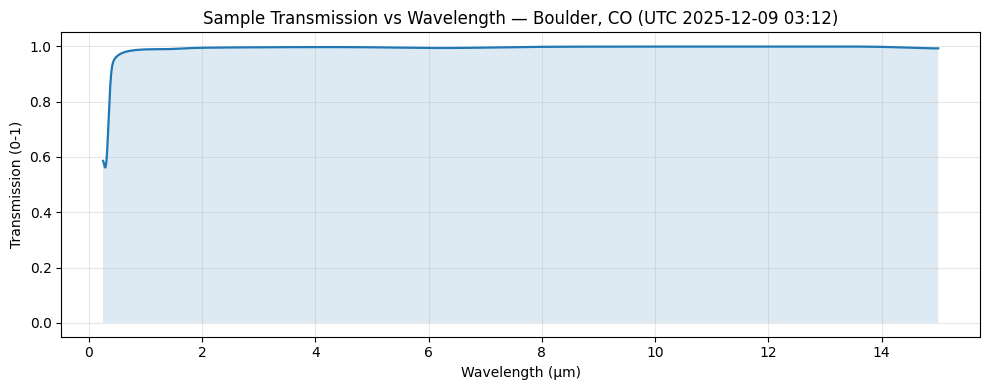

Mean visible transmission (0.4–0.7 µm): 0.97
Mean NIR transmission (0.7–2.5 µm): 0.99


In [3]:
# Python code to generate a prototype "interactive" transmission modeling view.
# This runs here as a notebook-style demo for the sample inputs: current UTC date/time at Boulder, CO.
# It produces:
#  - a plot of transmission vs wavelength for a simple physics-inspired model
#  - a world map (folium) saved to /mnt/data and displayed as HTML link
#  - displays the uploaded placeholder image (path provided by developer instruction)
#
# The code is written so you can later wire up ipywidgets or a GUI to call compute_transmission()
# with arbitrary date/time/lat/lon/altitude/wavelengths.
#
# NOTE: This is a prototype/demo. For production-grade radiative transfer use libradtran, LOWTRAN, or line-by-line tools.
#
# File paths and outputs are saved under /mnt/data so you can download them.
from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import folium
from IPython.display import display, HTML, Image

# Uploaded placeholder image path (provided by developer instructions)
uploaded_image_path = "0aebadae-a8cb-41e6-9fc6-9417be24578f.png"

# Sample input: current datetime UTC and Boulder, CO coordinates
sample_dt = datetime.now(timezone.utc)
boulder_lat = 40.0150
boulder_lon = -105.2705
boulder_alt_km = 1.6  # approx altitude in km

# Wavelength grid in micrometers (0.25 µm UV to 15 µm mid-IR)
wavelengths_um = np.concatenate([np.linspace(0.25, 1.0, 150), np.linspace(1.0, 15.0, 400)])

def extinction_coefficient_empirical(wl_um):
    """
    Empirical extinction coefficient vs wavelength (per unit column)
    This is a toy model combining approximate contributions:
      - ozone/UV absorption at short wavelengths
      - Rayleigh scattering (~ 1/lambda^4) in visible
      - water vapor / CO2 bands in near-IR (broad bumps)
    Returns a non-negative kappa(wl) in arbitrary units (per unit column)
    """
    wl = wl_um
    # ozone UV peak around 0.25-0.35 um
    ozone = 0.8 * np.exp(-((wl - 0.30)/0.06)**2)
    # Rayleigh scattering (normalized)
    rayleigh = 0.5 * (1.0 / (wl**4))
    # broad H2O absorption bands (near-IR bumps)
    h2o = 0.6 * np.exp(-((wl - 1.4)/0.35)**2) + 0.9 * np.exp(-((wl - 6.3)/1.2)**2)
    # CO2 band around 15 µm (longwave)
    co2 = 0.7 * np.exp(-((wl - 15.0)/0.8)**2)
    # baseline aerosol / turbidity
    aerosol = 0.02 * (1.0 / (wl**0.8))
    k = ozone + 0.005*rayleigh + 0.01*h2o + 0.02*co2 + aerosol
    # scale to reasonable optical depth per unit column
    return np.maximum(k, 0.0)

def compute_surface_pressure(lat_deg, alt_km):
    """
    Very simple barometric approximation for surface pressure (hPa) as function of altitude.
    Not meteorologically accurate; used here as demo.
    """
    # Sea-level standard pressure 1013.25 hPa; scale height ~ 7.64 km
    return 1013.25 * np.exp(-alt_km / 7.64)

def compute_transmission(lat, lon, alt_km, dt_utc, wavelengths_um, airmass=1.0, turbidity=1.0):
    """
    Compute a simple transmission curve T(lambda) using an empirical optical-depth model.
    Parameters:
      - lat, lon: geographic (unused by simple model, but kept for API-consistency)
      - alt_km: altitude above sea level (km)
      - dt_utc: datetime (UTC) for potential time-dependent extensions
      - wavelengths_um: numpy array of wavelengths (micrometers)
      - airmass: geometric airmass factor (1 = zenith)
      - turbidity: multiplier for aerosols / turbidity
    Returns:
      - wavelengths_um, transmission (0..1), optical_depth
    """
    # Estimate column "pressure proxy" using barometric formula
    p_hpa = compute_surface_pressure(lat, alt_km)
    column_proxy = p_hpa / 1013.25  # 1 at sea level, less at altitude
    # extinction coefficient per unit column
    kappa = extinction_coefficient_empirical(wavelengths_um)
    # Optical depth tau = kappa * column_proxy * turbidity * airmass * scaling
    tau = kappa * column_proxy * turbidity * airmass * 0.6
    # Transmission
    T = np.exp(-tau)
    return wavelengths_um, T, tau

# Compute for the sample input (Boulder now)
wl, T_boulder, tau_boulder = compute_transmission(boulder_lat, boulder_lon, boulder_alt_km, sample_dt, wavelengths_um)

# Plot transmission vs wavelength
plt.figure(figsize=(10,4))
plt.plot(wl, T_boulder, linewidth=1.6)
plt.fill_between(wl, T_boulder, alpha=0.15)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Transmission (0-1)")
plt.title(f"Sample Transmission vs Wavelength — Boulder, CO (UTC {sample_dt.strftime('%Y-%m-%d %H:%M')})")
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)
out_plot_path = "transmission_boulder.png"
plt.tight_layout()
plt.savefig(out_plot_path, dpi=150)
plt.show()

def get_key_transmissions(wl, T, report=False):
    # Make a quick summary heat indicator (mean transmission in visible and near-IR bands)
    vis_mask = (wl >= 0.4) & (wl <= 0.7)
    nir_mask = (wl >= 0.7) & (wl <= 2.5)
    vis_mean = float(np.mean(T_boulder[vis_mask]))
    nir_mean = float(np.mean(T_boulder[nir_mask]))

    if report:
        summary_text = f"Mean visible transmission (0.4–0.7 µm): {vis_mean:.2f}\nMean NIR transmission (0.7–2.5 µm): {nir_mean:.2f}"
        print(summary_text)

    return vis_mean, nir_mean

vis_mean, nir_mean = get_key_transmissions(wl, T_boulder, report=True)

In [4]:
alt = 1000 # km
longitudes = []
latitudes = []
vis_transmissions = []
nir_transmissions = []

for lat in range(-180, 180, 30):
    for lon in range(-90, 90, 30):
        wl, T, tau = compute_transmission(lat, lon, alt, sample_dt, wavelengths_um)
        vis_mean, nir_mean = get_key_transmissions(wl, T)
        vis_transmissions.append(vis_mean)
        nir_transmissions.append(nir_mean)
        longitudes.append(lon)
        latitudes.append(lat)
        
grid = pd.DataFrame()
grid['Latitude'] = latitudes
grid['Longitude'] = longitudes
grid['Mean Visual Transmission'] = vis_transmissions
grid['Mean NIR Transmission'] = nir_transmissions

In [5]:
grid.head()

,Latitude,Longitude,Mean Visual Transmission,Mean NIR Transmission
0,-180,-90,0.966009,0.988562
1,-180,-60,0.966009,0.988562
2,-180,-30,0.966009,0.988562
3,-180,0,0.966009,0.988562
4,-180,30,0.966009,0.988562


In [6]:
grid.describe()

,Latitude,Longitude,Mean Visual Transmission,Mean NIR Transmission
count,72.000000,72.0000,7.200000e+01,7.200000e+01
mean,-15.000000,-15.0000,9.660094e-01,9.885621e-01
std,104.288333,51.5943,5.590071e-16,3.354042e-16
min,-180.000000,-90.0000,9.660094e-01,9.885621e-01
25%,-97.500000,-60.0000,9.660094e-01,9.885621e-01
50%,-15.000000,-15.0000,9.660094e-01,9.885621e-01
75%,67.500000,30.0000,9.660094e-01,9.885621e-01
max,150.000000,60.0000,9.660094e-01,9.885621e-01


In [7]:
import folium
from folium.plugins import HeatMap

# Assume grid dataframe exists with Latitude, Longitude, Values

# Center map around global mean
map_center = [grid["Latitude"].mean(), grid["Longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=2, tiles="CartoDB positron")

# HeatMap expects a list of [lat, lon, weight]
heat_data = grid[["Latitude", "Longitude", "Mean NIR Transmission"]].values.tolist()

HeatMap(
    heat_data,
    min_opacity=0.3,
    radius=10,
    blur=15,
    max_zoom=1,
).add_to(m)

#m.save("world_heatmap.html")
m

In [8]:


# Create a folium world map with a marker at Boulder and a popup showing mean transmission
map_center = [boulder_lat, boulder_lon]
tiles = "https://stamen-tiles.a.ssl.fastly.net/terrain/{z}/{x}/{y}.jpg" # "Stamen Terrain"
m = folium.Map(location=map_center, zoom_start=4, tiles=tiles, attr="Map tiles by Stamen Design, CC BY 3.0 — Data © OpenStreetMap contributors")
popup_html = f"<b>Boulder, CO (sample)</b><br>{sample_dt.strftime('%Y-%m-%d %H:%M UTC')}<br>" \
             f"Mean VIS T: {vis_mean:.2f}<br>Mean NIR T: {nir_mean:.2f}"

folium.Marker(location=map_center, popup=popup_html, tooltip="Boulder, CO").add_to(m)

# Save map to file
map_out = "boulder_map.html"
m.save(map_out)

# Display the uploaded placeholder image (file provided by developer) and links to outputs
#display(Image(uploaded_image_path, width=420))
# display(HTML(f"<p><b>Generated outputs saved to:</b></p>"
#              f"<ul>"
#              f"<li><a href='file://{out_plot_path}'>Transmission plot (PNG)</a></li>"
#              f"<li><a href='file://{map_out}'>Boulder map (HTML)</a></li>"
#              f"</ul>"))

# Also print the local file paths for convenience
out_files = {"plot_png": out_plot_path, "map_html": map_out, "placeholder_image": uploaded_image_path}
out_files

{'plot_png': 'transmission_boulder.png',
 'map_html': 'boulder_map.html',
 'placeholder_image': '0aebadae-a8cb-41e6-9fc6-9417be24578f.png'}